In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score



online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)


X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets


merged_df = pd.concat([X, y], axis=1)

print(merged_df.head())


   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

In [36]:
merged_df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [38]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

This is an interesting and fun dataset, with some great opportunities for insights. Here, we have a few items that are important to consider. Based on the description of this data, lets consider the following variables:

1) Administrative - Pertains to the type of webpage visited, and the count.
2) Administrative Duration - Represents the duration of time spent on the website.
3) Informational - Pertains to the type of webpage visited (informational), and the count.
4) Informational Duration - duration of time spent on these types of websites.
5) Product Related - This would be a product related website.
6) Product Duration of time on a product related website.
7) Bounce Rates - % of time the user left after visiting the first page. 
8) Exit Rates - % of time the webpage was the last one visited. 
9) Page Values - The average value for a web page that a user visited before completing an e-commerce transaction
10) Special Day - Closeness of purchase to a special day
11) Month - Month of purchase.
12) Operating Systems - OS of the user. 
13) Browser - Browser type
14) Region - Region of the purchaser
15) Traffic Type - Source type 
16) Visitor Type - returning or new customer. 
17) Weekend - Purchase on a weekend or weekday. 
18) Revenue - Amount of purchase. 


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
df_encoded = pd.get_dummies(merged_df, drop_first=True, dtype=int)
le = LabelEncoder()
df_encoded['Revenue'] = le.fit_transform(df['Revenue'])

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_encoded)
scaled_df = pd.DataFrame(scaled_array, columns=df_encoded.columns)

corr = scaled_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation of Variables (Scaled)")
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [43]:
Some weak to moderate correlations exist within the dataset, with stronger correlations being between different measures of the same variable (i.e. count of website vs. duration). One notable moderation correlation exists between page values and revenue. This may benefit from a further analysis of how revenue is distributed across these variables.   

SyntaxError: invalid syntax (2267045769.py, line 1)

<Axes: xlabel='Revenue', ylabel='count'>

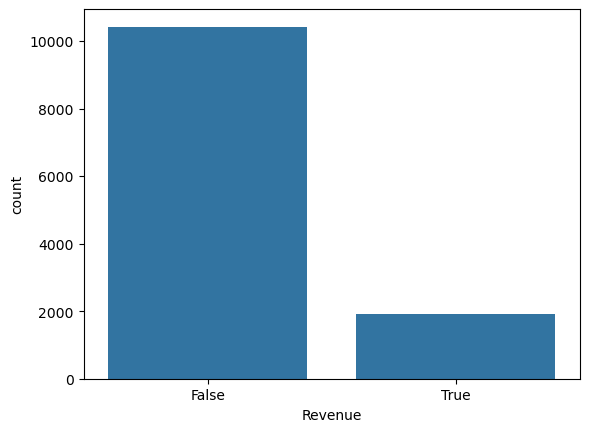

In [45]:
sns.countplot(data=merged_df, x="Revenue")

In [47]:
print(merged_df['Revenue'].value_counts())
purchase_rate = merged_df['Revenue'].mean()
print(f"purchase likelihood: {purchase_rate * 100:.2f}%")

Revenue
False    10422
True      1908
Name: count, dtype: int64
purchase likelihood: 15.47%


<Axes: xlabel='OperatingSystems', ylabel='count'>

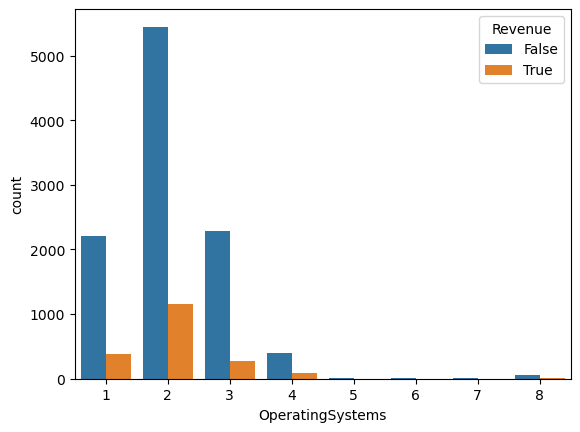

In [49]:
sns.countplot(data=merged_df, x="OperatingSystems", hue="Revenue")

<Axes: xlabel='OperatingSystems', ylabel='Revenue'>

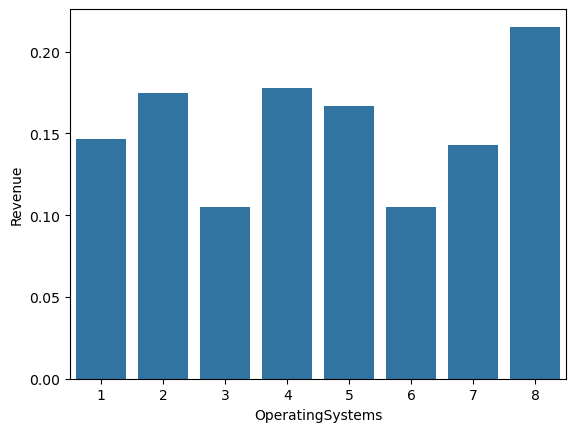

In [51]:
sns.barplot(data=merged_df, x="OperatingSystems", y="Revenue", errorbar=None)

In [53]:
os_counts = merged_df["OperatingSystems"].value_counts().sort_index()
print(os_counts)

OperatingSystems
1    2585
2    6601
3    2555
4     478
5       6
6      19
7       7
8      79
Name: count, dtype: int64


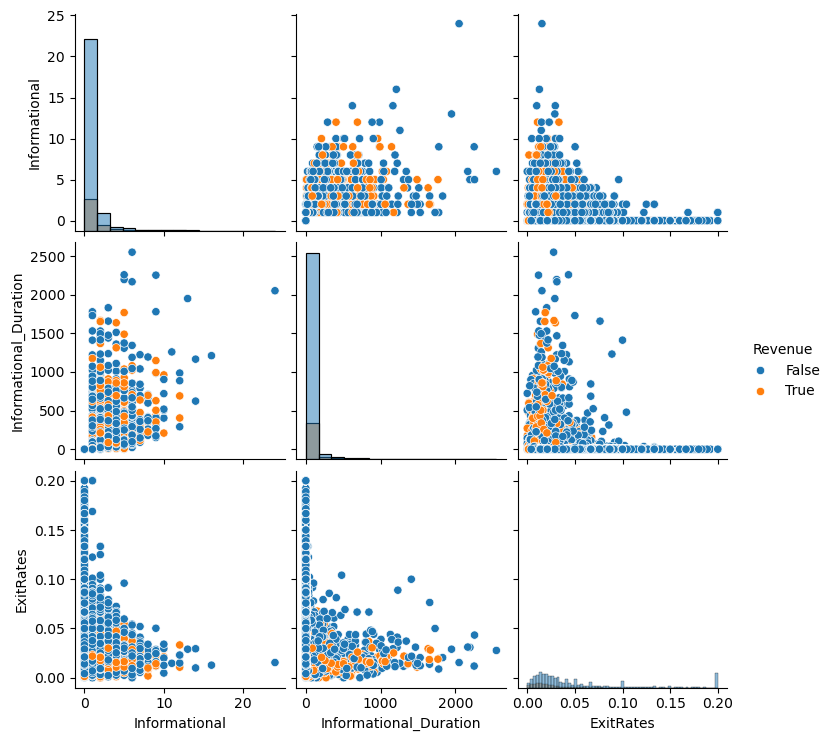

In [56]:
sns.pairplot(merged_df, vars=["Informational", "Informational_Duration", "ExitRates"], hue="Revenue", diag_kind="hist")

Text(0.5, 1.0, 'Conversion Rate: Visited Informational vs Not')

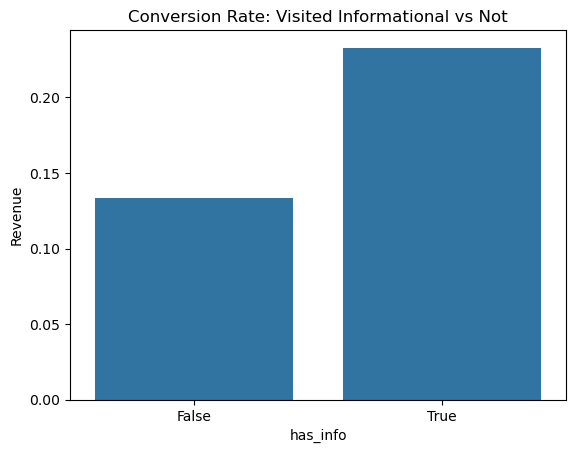

In [57]:
df = merged_df.copy()
df["has_info"] = (df["Informational"] > 0) | (df["Informational_Duration"] > 0)

cr = df.groupby("has_info")["Revenue"].mean().rename("conversion_rate")

sns.barplot(data=df, x="has_info", y="Revenue", estimator=np.mean, errorbar=None)
plt.title("Conversion Rate: Visited Informational vs Not")

<Axes: xlabel='has_info', ylabel='count'>

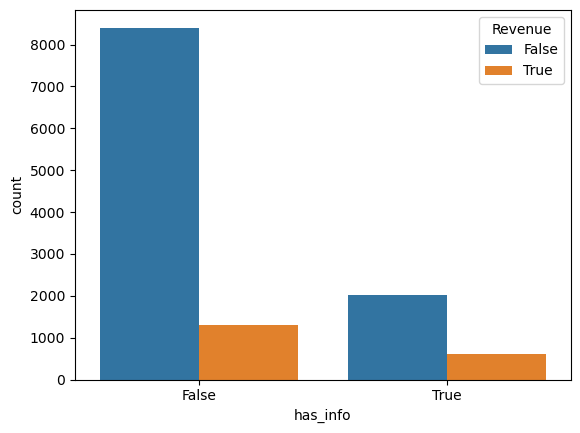

In [58]:
sns.countplot(
    data=df,
    x="has_info",
    hue="Revenue"
)

<Axes: xlabel='Revenue', ylabel='Informational_Duration'>

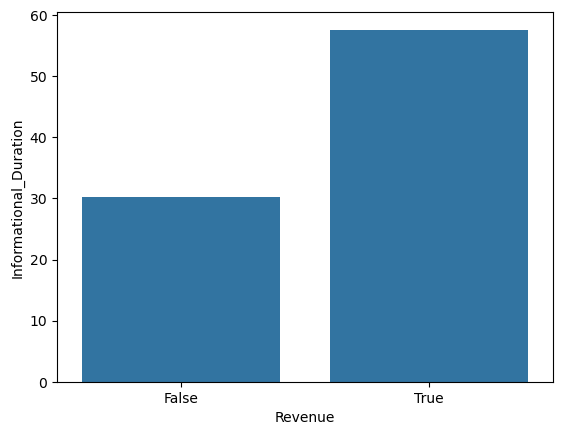

In [59]:
sns.barplot(data=merged_df, x = "Revenue", y = "Informational_Duration", errorbar=None)

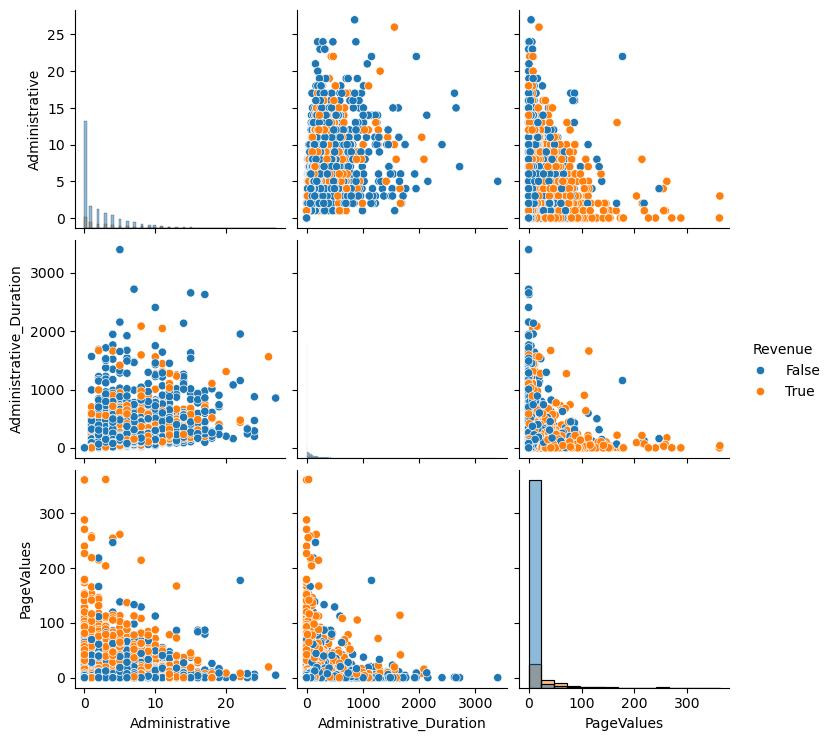

In [60]:
sns.pairplot(merged_df, vars=["Administrative", "Administrative_Duration", "PageValues"], hue="Revenue", diag_kind="hist")

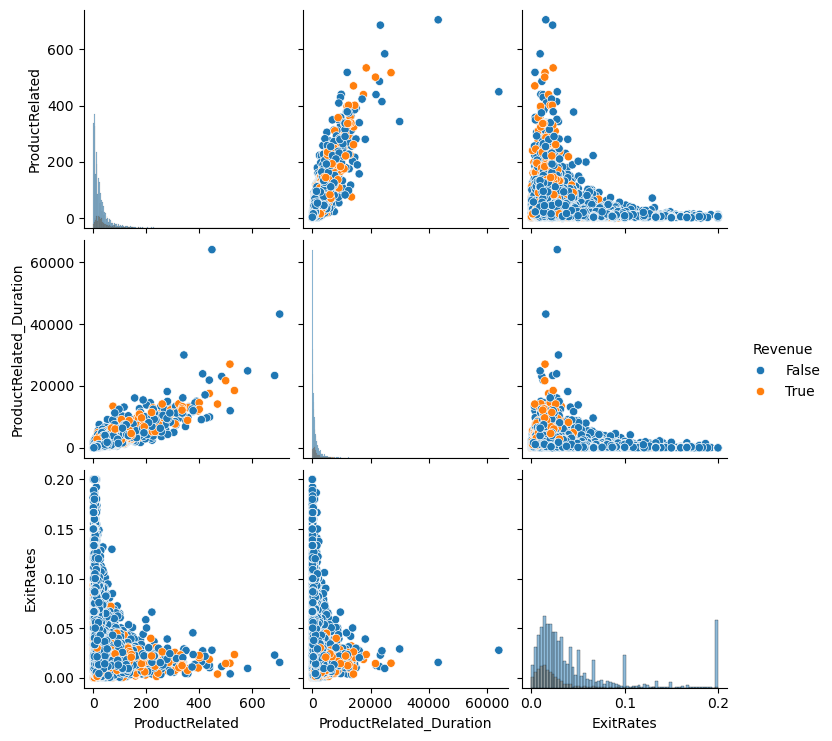

In [61]:
sns.pairplot(merged_df, vars=["ProductRelated", "ProductRelated_Duration", "ExitRates"], hue="Revenue", diag_kind="hist")

Similar patterns are noted with visits to informationa

<Axes: xlabel='Month', ylabel='count'>

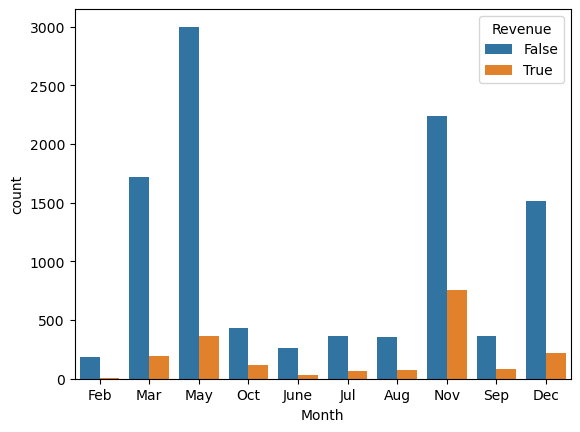

In [67]:
sns.countplot(data=merged_df, x="Month", hue = "Revenue")

In [68]:
month_counts = merged_df["Month"].value_counts().sort_index()
print(month_counts)

Month
Aug      433
Dec     1727
Feb      184
Jul      432
June     288
Mar     1907
May     3364
Nov     2998
Oct      549
Sep      448
Name: count, dtype: int64


<Axes: xlabel='Month', ylabel='Revenue'>

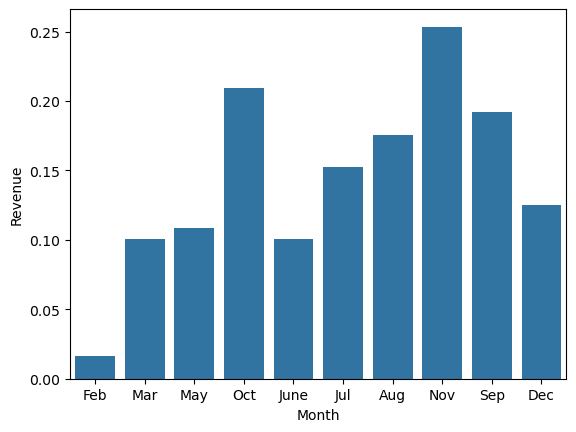

In [69]:
sns.barplot(data=merged_df, x="Month", y = "Revenue", errorbar=None)

<Axes: xlabel='VisitorType', ylabel='count'>

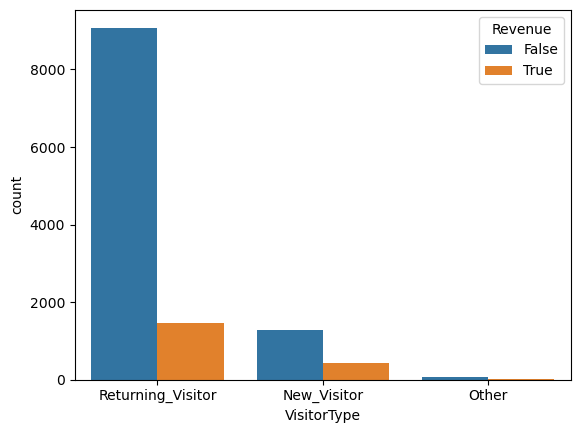

In [70]:
sns.countplot(data=merged_df, x="VisitorType", hue = "Revenue")

In [71]:
vis_counts = merged_df["VisitorType"].value_counts().sort_index()
print(vis_counts)

VisitorType
New_Visitor           1694
Other                   85
Returning_Visitor    10551
Name: count, dtype: int64


<Axes: xlabel='VisitorType', ylabel='Revenue'>

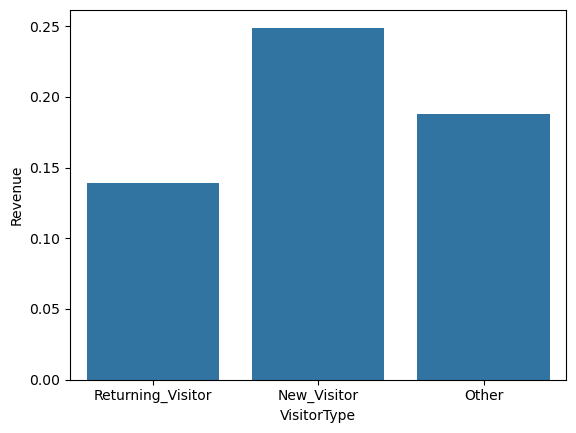

In [72]:
sns.barplot(data=merged_df, x="VisitorType", y = "Revenue", errorbar=None)

<Axes: xlabel='VisitorType', ylabel='PageValues'>

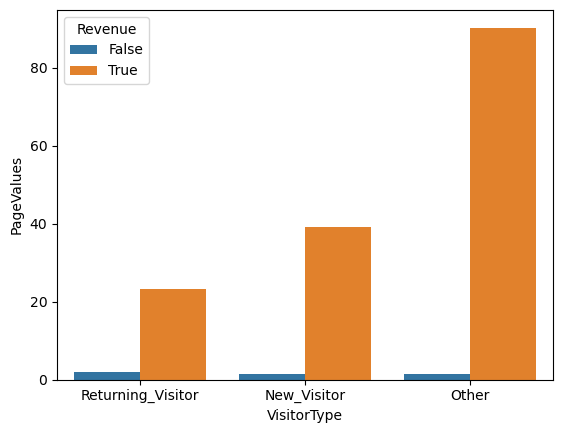

In [73]:
sns.barplot(data=merged_df, x="VisitorType", y = "PageValues", hue="Revenue", errorbar=None)

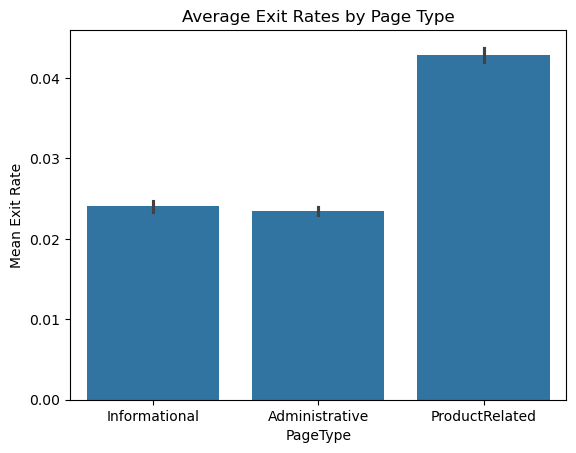

In [74]:
summary = {
    "Informational": merged_df.loc[merged_df["Informational"] > 0, "ExitRates"].mean(),
    "Administrative": merged_df.loc[merged_df["Administrative"] > 0, "ExitRates"].mean(),
    "ProductRelated": merged_df.loc[merged_df["ProductRelated"] > 0, "ExitRates"].mean()
}

pd.Series(summary).sort_values(ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

df_long = pd.melt(
    merged_df,
    id_vars=["ExitRates"],
    value_vars=["Informational", "Administrative", "ProductRelated"],
    var_name="PageType",
    value_name="Count"
)

df_long = df_long[df_long["Count"] > 0]

sns.barplot(data=df_long, x="PageType", y="ExitRates", estimator=np.mean, errorbar="ci")
plt.title("Average Exit Rates by Page Type")
plt.ylabel("Mean Exit Rate")
plt.show()



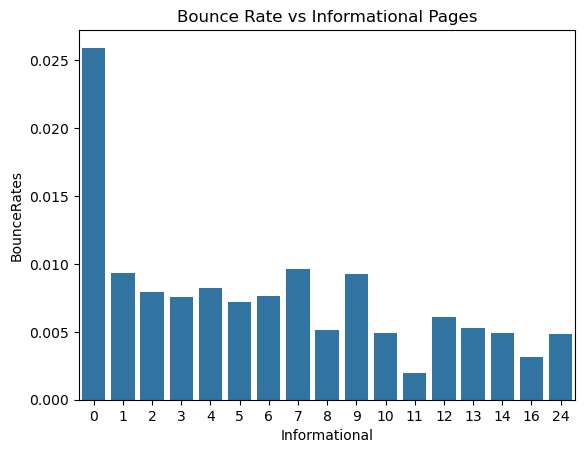

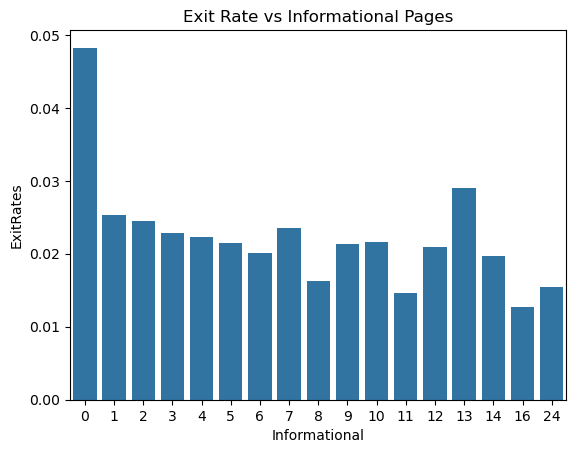

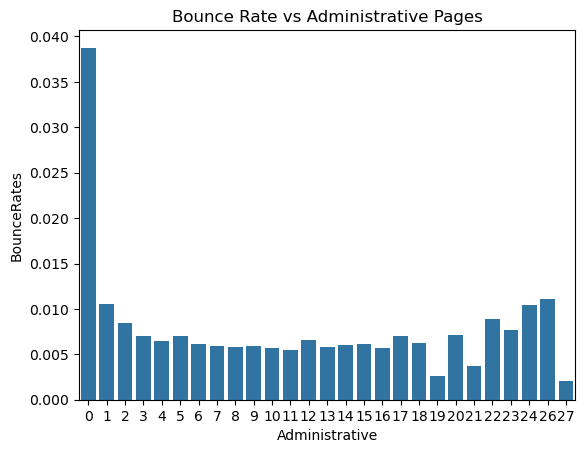

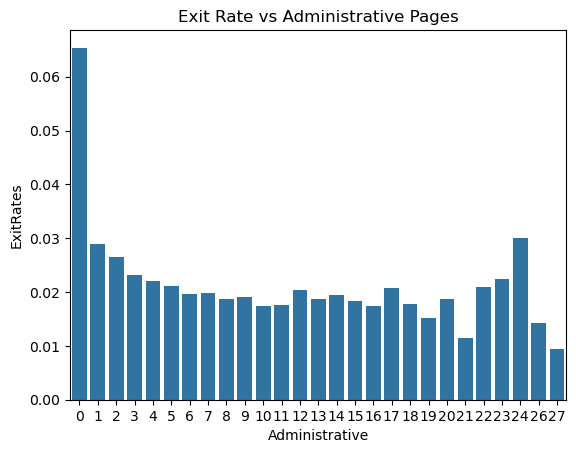

In [76]:
for col in ["Informational", "Administrative"]:
    sns.barplot(data=merged_df, x=col, y="BounceRates", errorbar=None)
    plt.title(f"Bounce Rate vs {col} Pages")
    plt.show()
    
    sns.barplot(data=merged_df, x=col, y="ExitRates", errorbar=None)
    plt.title(f"Exit Rate vs {col} Pages")
    plt.show()


In [77]:
sns.scatterplot(merged_df, x="Administrative_Duration", y = "Bounce
Rates")

SyntaxError: unterminated string literal (detected at line 1) (3274552779.py, line 1)

There are some interesting traits to note about this bounce/ exit rates. First, it is observed that users were mostly likely to leave a web page on viewing the product information. This could suggest that reading the product details was enough for a user to determine if they were interested in viewing more/ purchasing an product (to be continued)

In [ ]:
sns.barplot(merged_df, x= "Weekend", y = "Revenue", errorbar=None)

In [ ]:
sns.barplot(merged_df, x= "Weekend", y = "PageValues", errorbar=None)

<Axes: xlabel='Weekend', ylabel='count'>

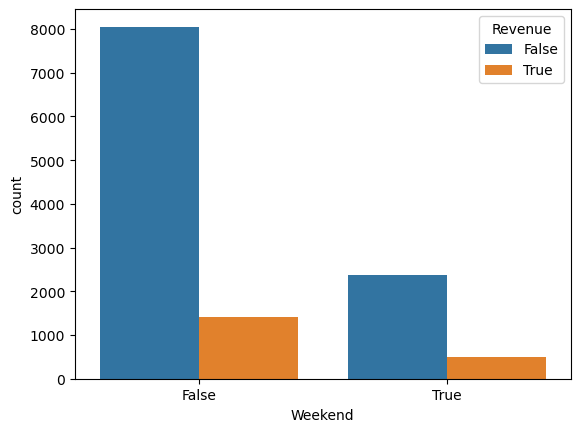

In [81]:
sns.countplot(merged_df, x= "Weekend", hue = "Revenue")

<Axes: xlabel='SpecialDay', ylabel='count'>

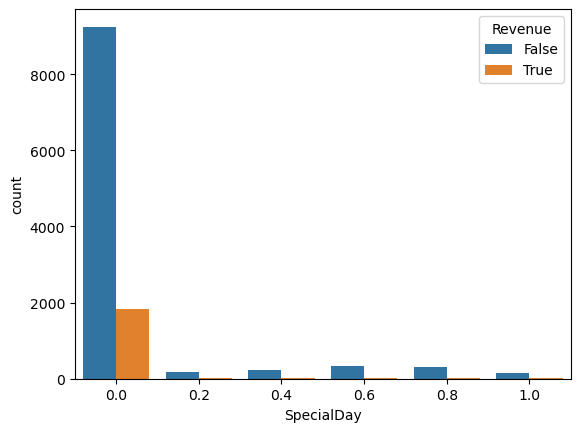

In [83]:
sns.countplot(merged_df, x= "SpecialDay", hue = "Revenue")

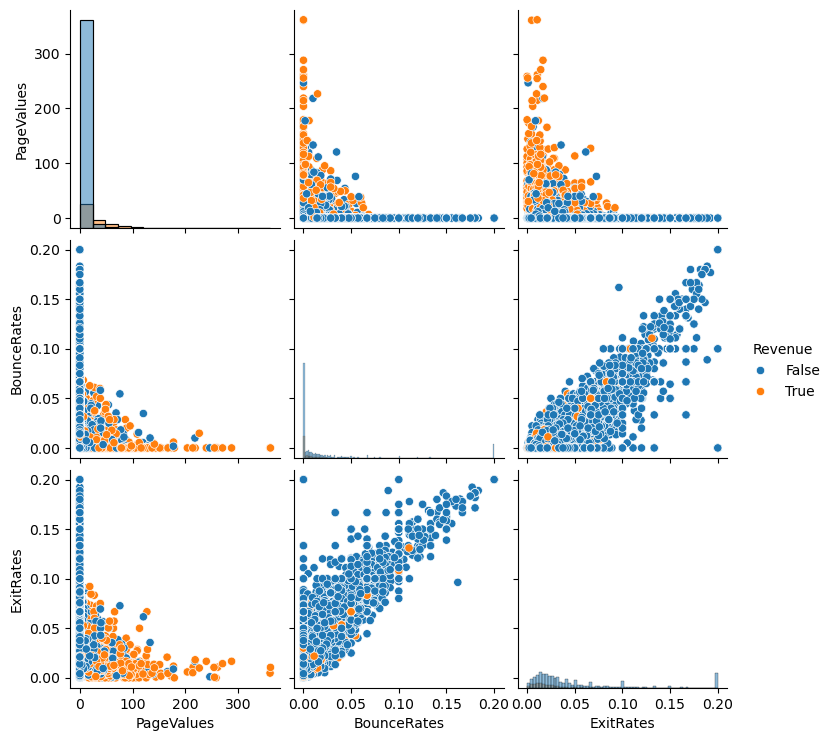

In [85]:
sns.pairplot(merged_df, vars=["PageValues", "BounceRates", "ExitRates"], hue="Revenue", diag_kind="hist")

The data shows some nuanced relationships between values within columns that do, or tend to nor result in a purchase. This is important to consider in light of the weak-moderate correlations within the dataset. While the variables within the dataset might have low correlation, some factors within the dataset are indicative of a highler likelihood of conversation than others. At the same time, higher likelihood of conversation, here, has mimxed value to business insights if the overall sum of purchases is low. This is only sometimes the case within the dataset, emphasizing the inherent nuances. 

A few notable insights:

1)Likelihood of conversation was mixed across users from different operating systems. While group 8 had the highest likelihood of conversation, they also represent a relatively smaller sum of purchases. Keeping in mind, this also represented a relatively smaller number of consumers. This means that if a user from group 8 accesses the webpage content, for some (currently unknown) reason they would more likely be making a purchase. 

2) Trends like counts within a value for each variable are, well, variable across predictors here. For example, there is class imbalance in visitory type, and # of purchases varying greatly across the months.

3) Factors like exit and bounce rates have some interesting traits. For example, most users seem to leave without viewing much or any information at all without making a purcahse. If they do start to visit facotrs like informational, admin, product related, factors of exit and bounce rates drop and stabilize across values.

Simply put, there are nuances within the dataset, meaning feature selection would respectively benefit from considering these factors. Because I am simply experimenting here, I have some feature selection and model options to consider. Previous research includes approaches like principle component analysis, or more maunaul discretized mutual information approaches. As the dataset shows unique converstion rates, with moderate to low correlation, I will experiment with manual discretization on sum of revenue and likelihood of conversion. Class imbalances will be handled through SMOTE as a first step.  

In [88]:
X = df_encoded.drop(columns=['Revenue'])
y = df_encoded['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [90]:
train_df = X_train.copy()
train_df['Revenue'] = y_train

# 2. Use qcut on just the training set — no leakage
train_df['PageValues_bin'] = pd.qcut(train_df['PageValues'], q=50, duplicates='drop')

# 3. Group by the bin and summarize Revenue
page_summary = train_df.groupby('PageValues_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={
    'sum': 'Purchases',
    'mean': 'ConversionRate'
})

print(page_summary)

                  count  Purchases  ConversionRate
PageValues_bin                                    
(-0.001, 0.58]     7694        292        0.037952
(0.58, 3.019]       197         66        0.335025
(3.019, 5.621]      197         71        0.360406
(5.621, 8.214]      197         74        0.375635
(8.214, 11.122]     198         96        0.484848
(11.122, 14.851]    197         99        0.502538
(14.851, 19.114]    197        109        0.553299
(19.114, 24.8]      197        125        0.634518
(24.8, 33.202]      198        134        0.676768
(33.202, 45.476]    197        138        0.700508
(45.476, 62.85]     197        161        0.817259
(62.85, 361.764]    198        161        0.813131


/var/folders/vp/zgl5wtv93gxgjlr0qhmm5_h80000gn/T/ipykernel_55678/437864132.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  page_summary = train_df.groupby('PageValues_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={


In [92]:
df_encoded['PageValues_bin'] = pd.qcut(df_encoded['PageValues'], q=50, duplicates='drop')

page_summary = df_encoded.groupby('PageValues_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={
    'sum': 'Purchases', 'mean': 'ConversionRate'
})

print(page_summary)

df_encoded['Exitrates_bin'] = pd.qcut(df_encoded['ExitRates'], q=50, duplicates='drop')

exit_summary = df_encoded.groupby('Exitrates_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={
    'sum': 'Purchases', 'mean': 'ConversionRate'
})

print(exit_summary)

                   count  Purchases  ConversionRate
PageValues_bin                                     
(-0.001, 0.291]     9617        377        0.039201
(0.291, 3.06]        247         82        0.331984
(3.06, 5.478]        246         91        0.369919
(5.478, 8.061]       247         95        0.384615
(8.061, 10.911]      246        116        0.471545
(10.911, 14.678]     247        129        0.522267
(14.678, 18.856]     247        132        0.534413
(18.856, 24.324]     246        151        0.613821
(24.324, 32.831]     247        159        0.643725
(32.831, 44.604]     246        173        0.703252
(44.604, 62.801]     247        205        0.829960
(62.801, 361.764]    247        198        0.801619
                    count  Purchases  ConversionRate
Exitrates_bin                                       
(-0.001, 0.00238]     250         83        0.332000
(0.00238, 0.004]      251         62        0.247012
(0.004, 0.00526]      253         75        0.296443
(0.0052

/var/folders/vp/zgl5wtv93gxgjlr0qhmm5_h80000gn/T/ipykernel_55678/3187389537.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  page_summary = df_encoded.groupby('PageValues_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={
/var/folders/vp/zgl5wtv93gxgjlr0qhmm5_h80000gn/T/ipykernel_55678/3187389537.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exit_summary = df_encoded.groupby('Exitrates_bin')['Revenue'].agg(['count', 'sum', 'mean']).rename(columns={
